In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 16, 10

### MLP

In [100]:
df = pd.read_csv('Data/daily_subs_fillna.csv')
df.head()

,date,subs
0,2021-04-01,2973
1,2021-04-02,2864
2,2021-04-03,3014
3,2021-04-04,3118
4,2021-04-05,2894


In [101]:
# keep real GDP only
keep_columns = ['subs']
df = df[keep_columns]
# rescale
df = df.dropna()

In [102]:
# split train & test data
n_train = int(len(df) * 0.8)
n_test = len(df) - n_train
train, test = df.iloc[0:n_train], df.iloc[n_train:len(df)]
print(len(train), len(test))

548 137


In [103]:
def get_timeseries(x, n_steps=1):
    x_ts, y_ts = [], []
    for ii in range(len(x) - n_steps):
        v = x.iloc[ii:(ii + n_steps)].values
        x_ts.append(v)
        w = x.iloc[ii + n_steps].values
        y_ts.append(w)
    return np.array(x_ts), np.array(y_ts)

In [104]:
n_steps = 16
n_features = 1

# convert to a time series dimension: [samples, n_steps, n_features]

x_train, y_train = get_timeseries(train, n_steps)
x_test, y_test = get_timeseries(test,n_steps)

print(x_train.shape, y_train.shape)

(532, 16, 1) (532, 1)


In [105]:
y_test

array([[ 7823],
       [ 8445],
       [ 8489],
       [ 8308],
       [ 8418],
       [ 8205],
       [ 7894],
       [ 7708],
       [ 8327],
       [ 8437],
       [ 8544],
       [ 8059],
       [ 8777],
       [ 7475],
       [ 6582],
       [ 8461],
       [ 8642],
       [ 8809],
       [ 9075],
       [ 9423],
       [10081],
       [ 7878],
       [ 9708],
       [ 8788],
       [ 9190],
       [ 9138],
       [ 9957],
       [ 9275],
       [ 8248],
       [ 9497],
       [ 9157],
       [ 8590],
       [ 8796],
       [ 9612],
       [11059],
       [ 9790],
       [10105],
       [ 9248],
       [ 9042],
       [ 9042],
       [ 8998],
       [ 8719],
       [ 8686],
       [ 8492],
       [ 9344],
       [ 9456],
       [ 9286],
       [ 9031],
       [ 9374],
       [ 8856],
       [ 9631],
       [ 9412],
       [ 9481],
       [ 9327],
       [ 9190],
       [ 9042],
       [ 8637],
       [ 9508],
       [ 9141],
       [ 9289],
       [ 9176],
       [ 9182],
       [

In [106]:
# define model
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(0.0001))

In [107]:
# fit model
history = model.fit(x_train, y_train,epochs=500,batch_size=32,validation_split=0.1,verbose=1,shuffle=False)

Epoch 1/500
15/15 [==============================] - 1s 11ms/step - loss: 2557421.7500 - val_loss: 419636.9375
Epoch 2/500
15/15 [==============================] - 0s 3ms/step - loss: 2482043.2500 - val_loss: 410509.1562
Epoch 3/500
15/15 [==============================] - 0s 3ms/step - loss: 2444350.7500 - val_loss: 412382.9375
Epoch 4/500
15/15 [==============================] - 0s 3ms/step - loss: 2406141.0000 - val_loss: 414231.8750
Epoch 5/500
15/15 [==============================] - 0s 3ms/step - loss: 2368179.0000 - val_loss: 412494.5312
Epoch 6/500
15/15 [==============================] - 0s 3ms/step - loss: 2329552.5000 - val_loss: 409981.4062
Epoch 7/500
15/15 [==============================] - 0s 3ms/step - loss: 2291821.5000 - val_loss: 407200.3438
Epoch 8/500
15/15 [==============================] - 0s 3ms/step - loss: 2254299.7500 - val_loss: 404196.7188
Epoch 9/500
15/15 [==============================] - 0s 3ms/step - loss: 2217963.5000 - val_loss: 401584.0625
Epoch 10/

In [108]:
# tạo một biến toàn giá trị 0 shape tương tự với x_test
x_test_fake = np.zeros_like(y_test)
x_test_fake.shape

(121, 1)

4/4 [==============================] - 0s 2ms/step


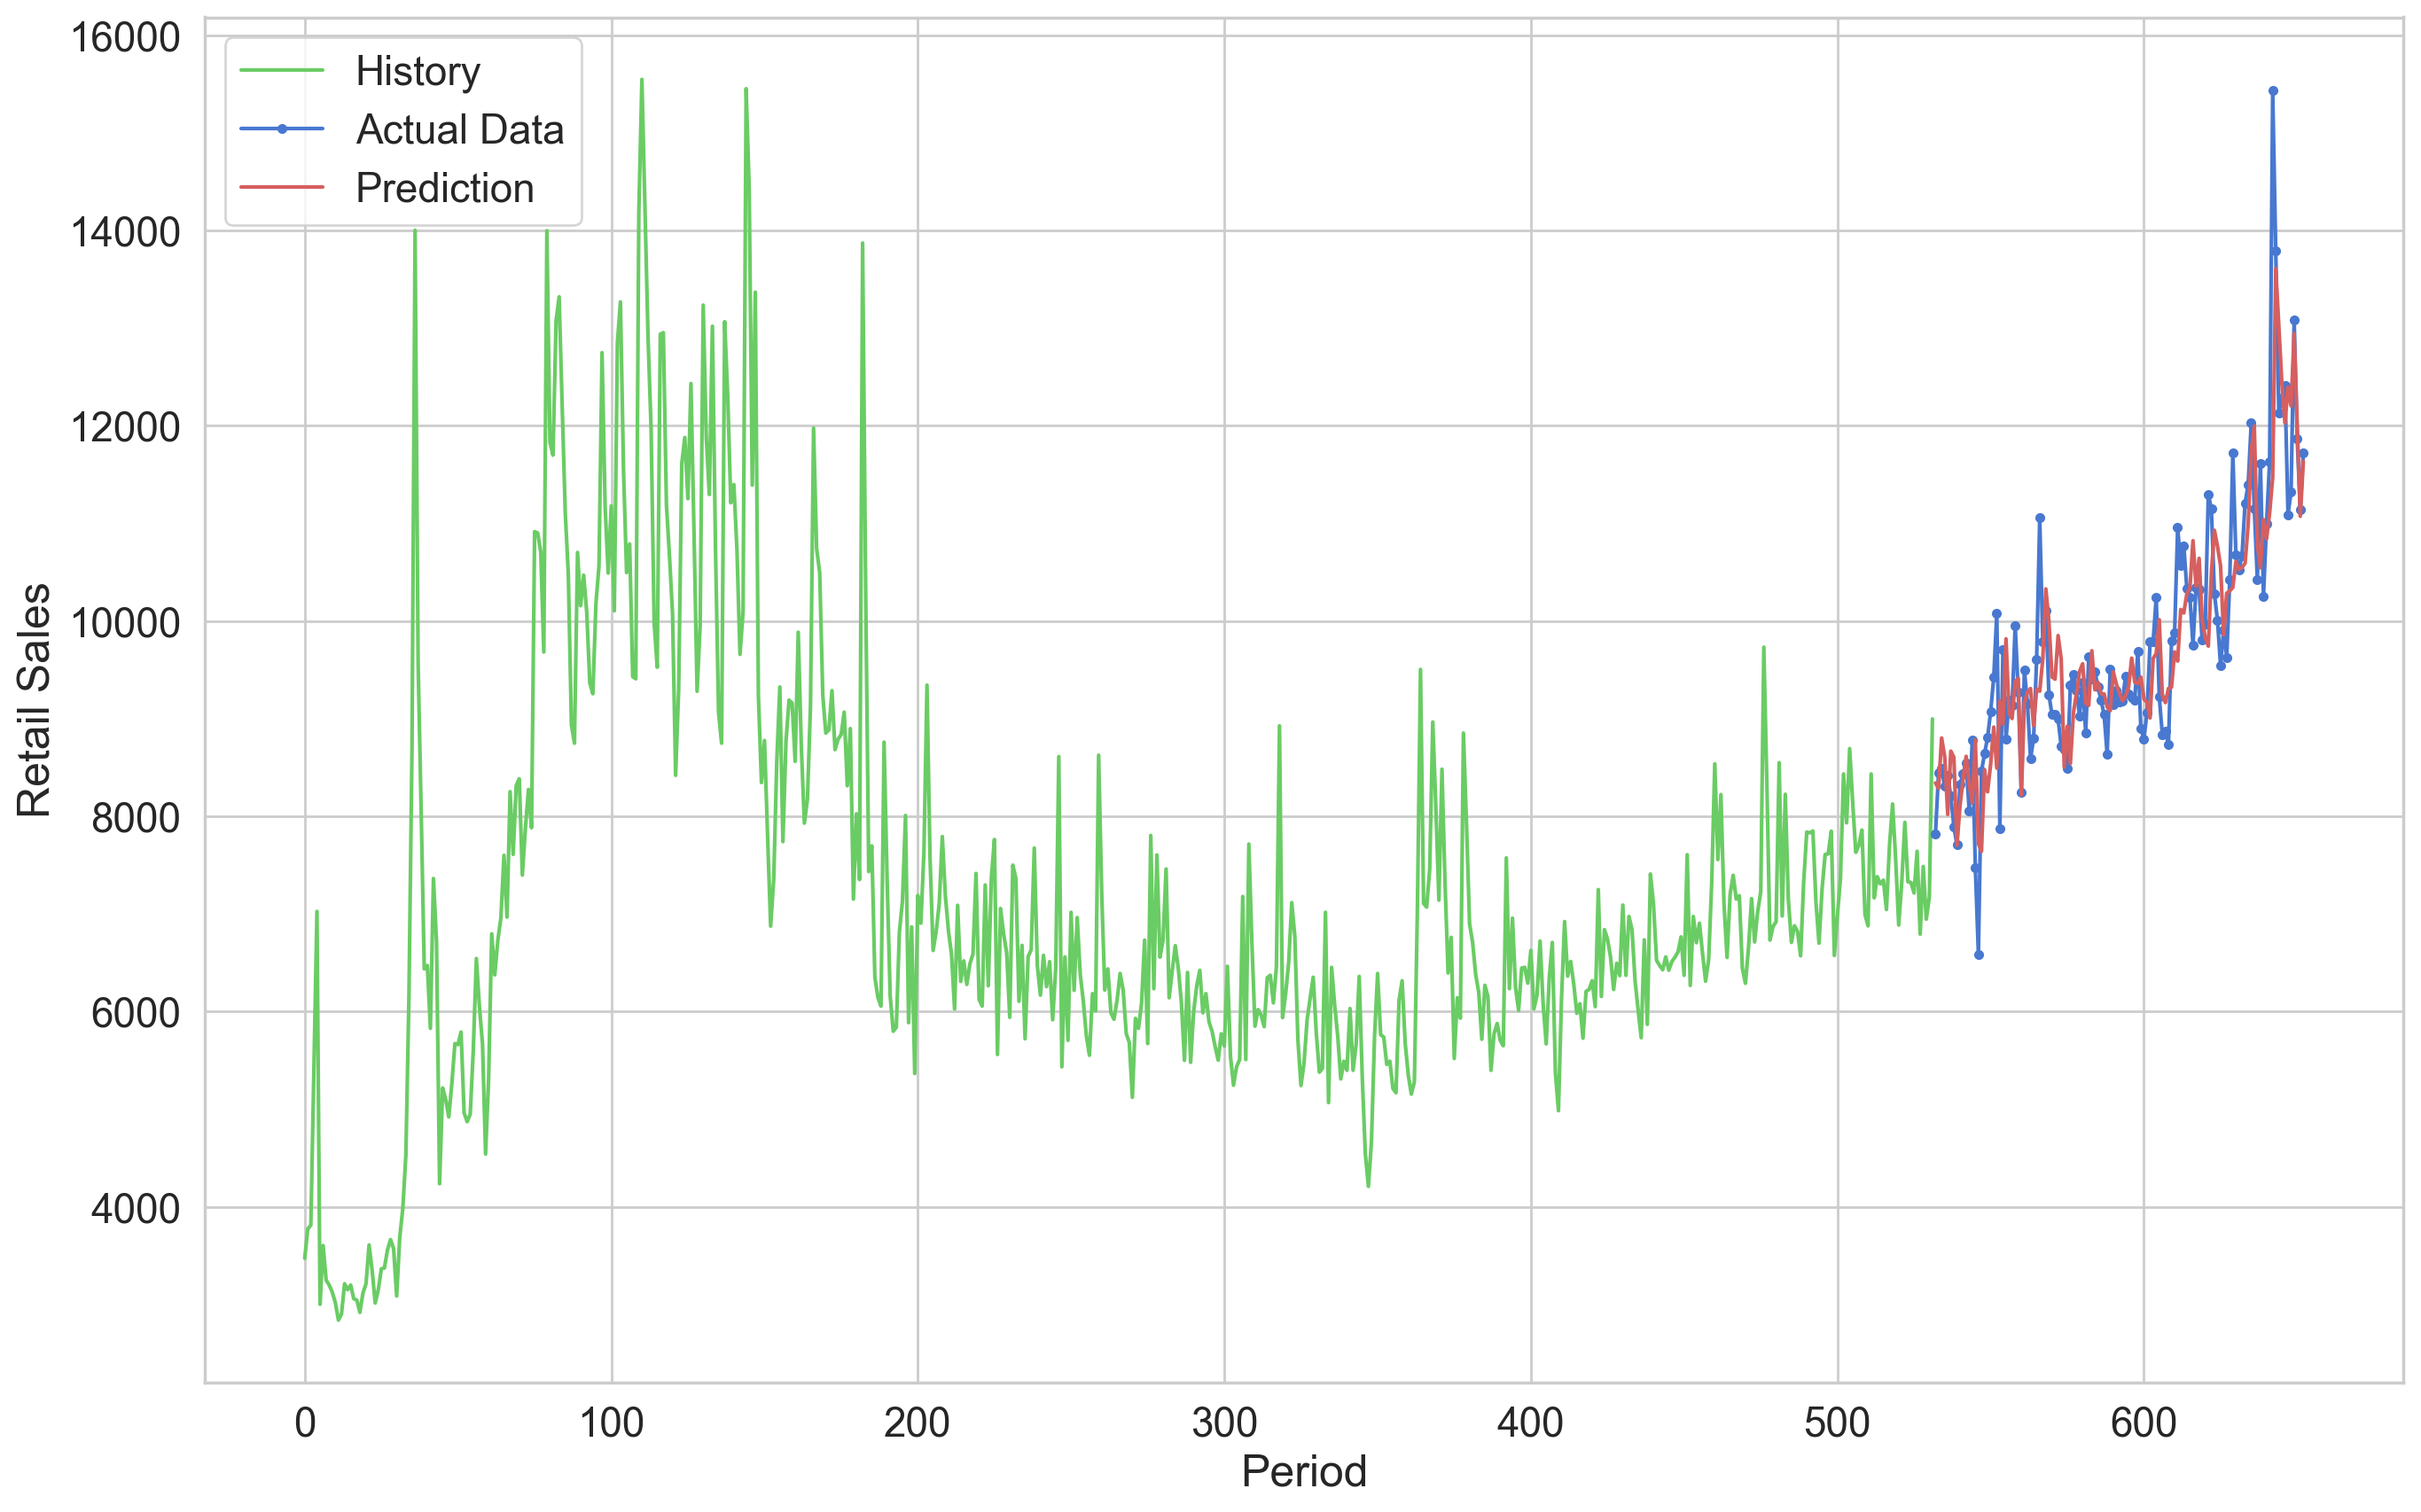

In [109]:
y_pred = model.predict(x_test)
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="Actual Data")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="Prediction")
plt.ylabel('Retail Sales')
plt.xlabel('Period')
plt.legend()
plt.show();

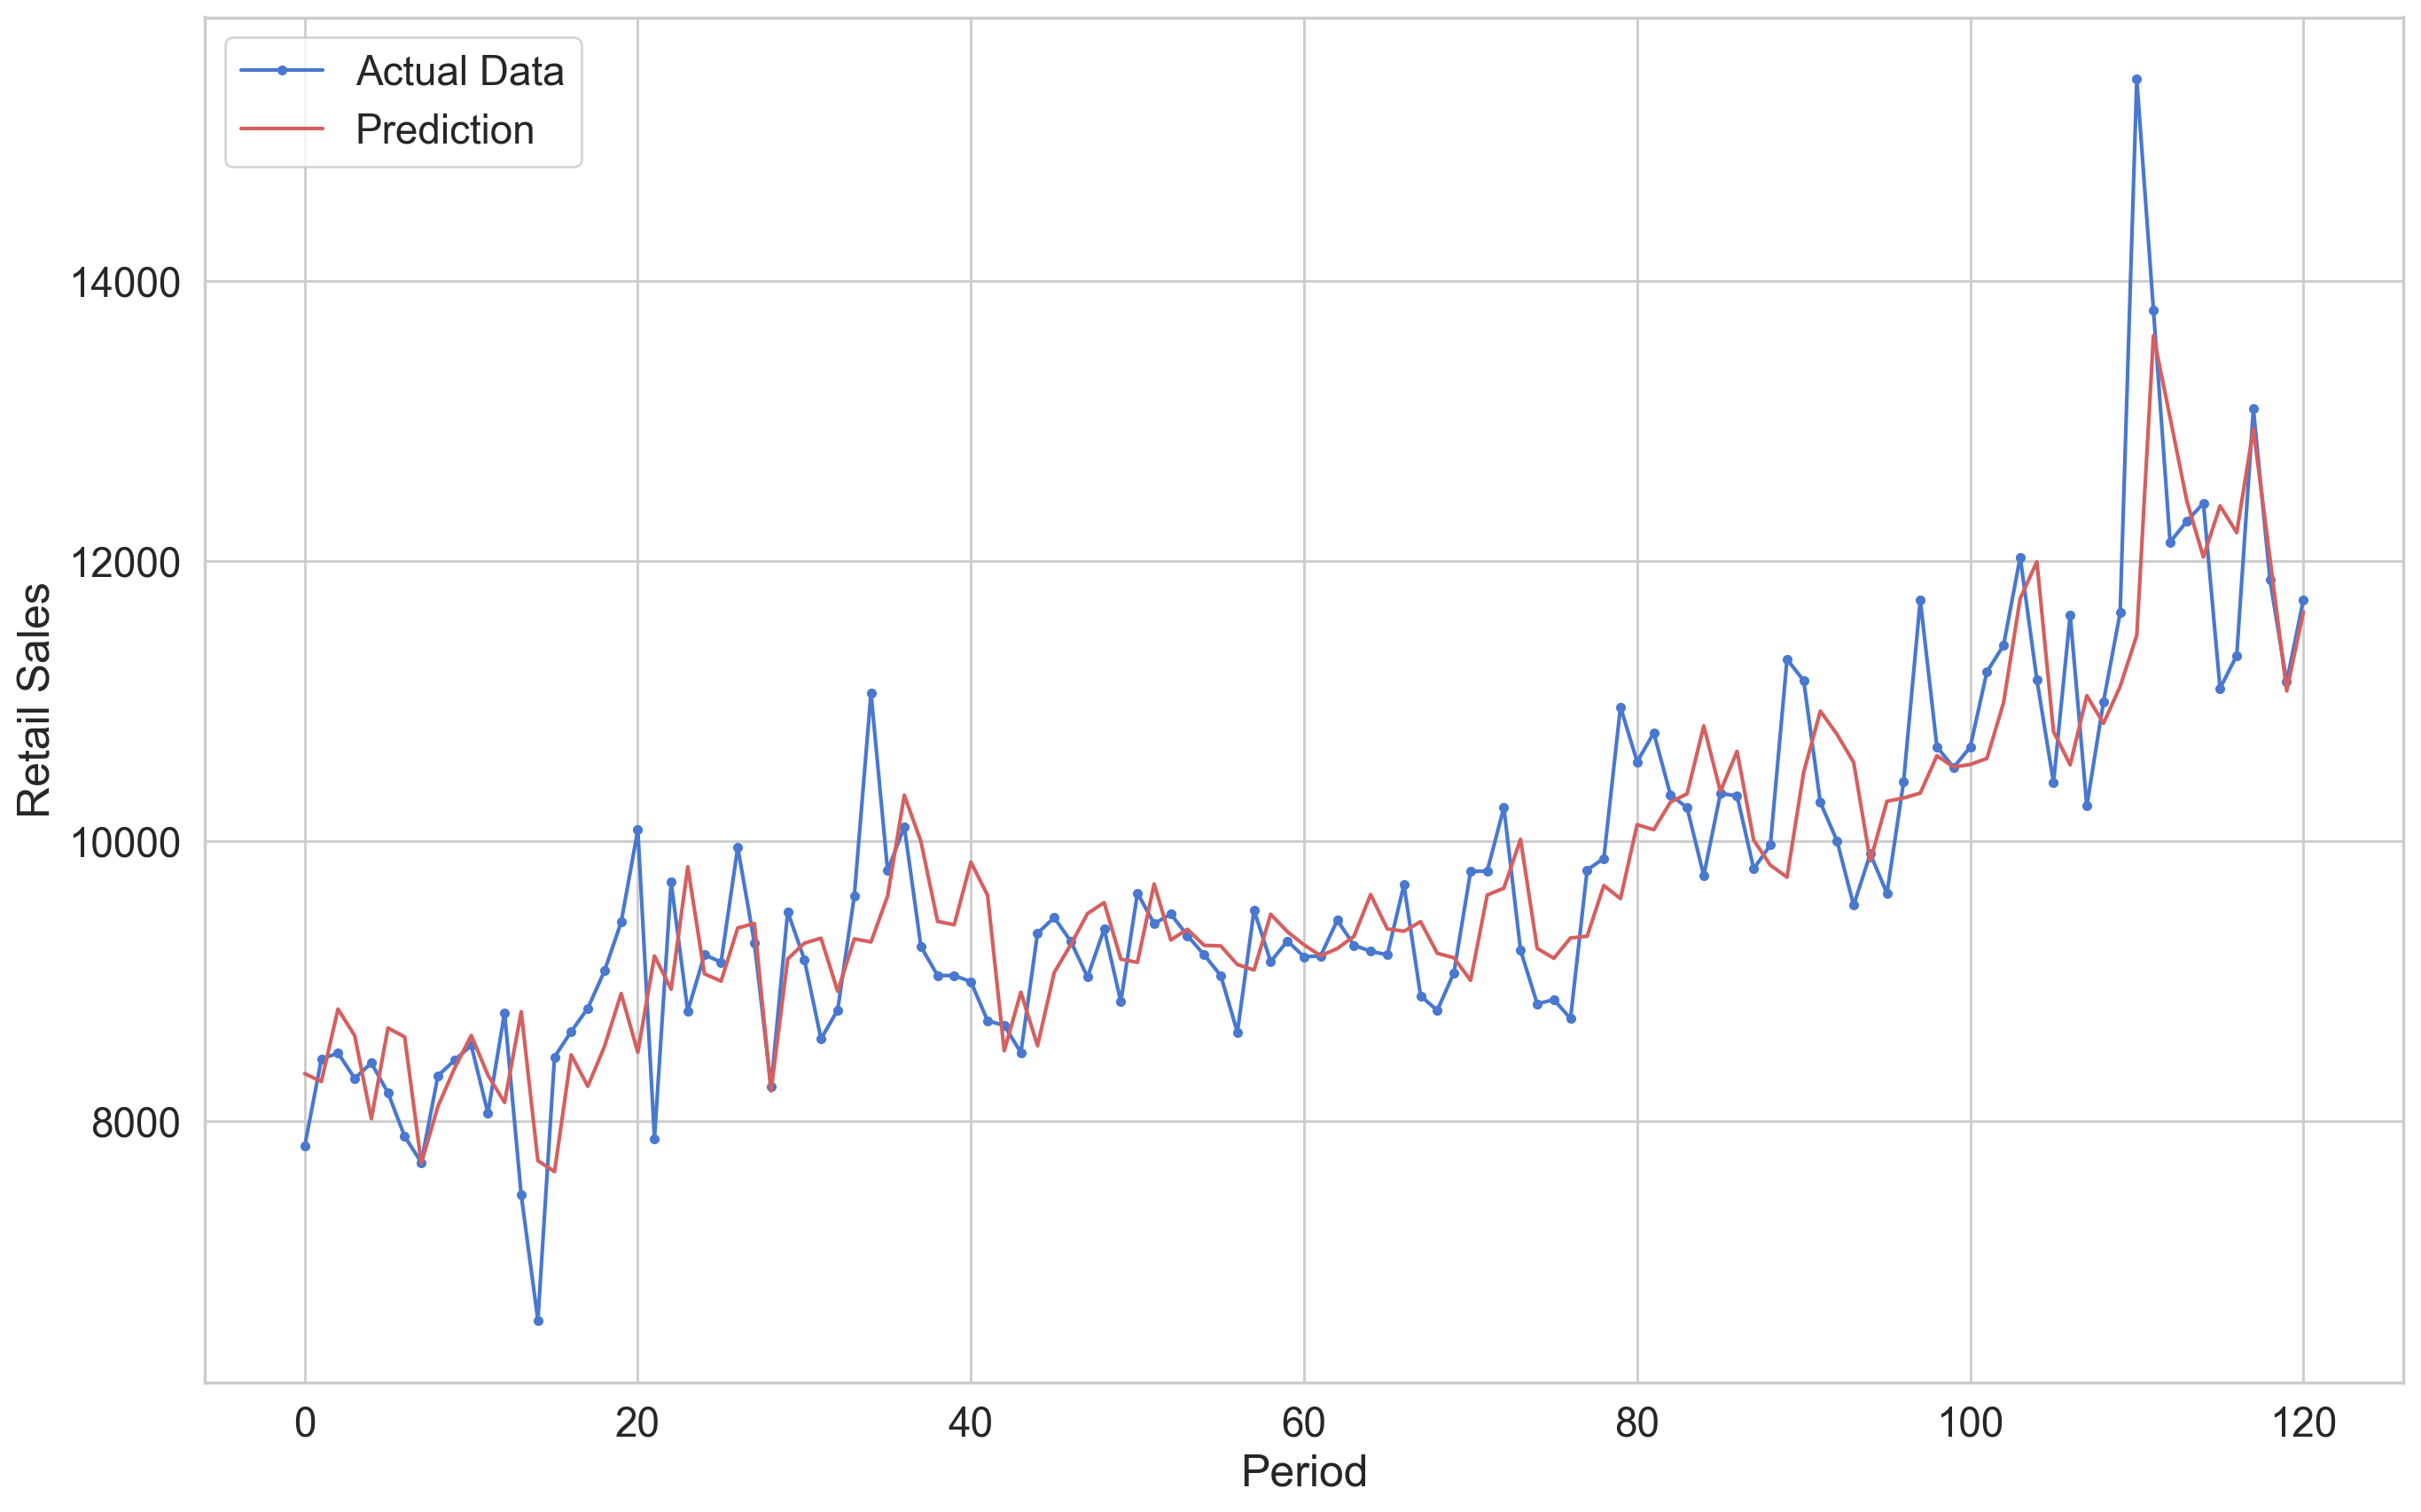

In [110]:
plt.plot(y_test, marker='.', label="Actual Data")
plt.plot(y_pred, 'r', label="Prediction")
plt.ylabel('Retail Sales')
plt.xlabel('Period')
plt.legend()
plt.show();

In [111]:
# tính rmse
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 695.803


In [112]:
# tạo hàm dự báo cho một biến đầu vào
def forecast(subs, model, days):
    # tạo list pred chứa days phần tử 0
    pred = [0] * days
    # tạo dãy input từ 16 subs cuối cùng
    # dự báo cho days ngày tiếp theo
    for i in range(days):
        x_input = subs[-16:]
        x_input = x_input.reshape((1, n_steps))
        y_pred = model.predict(x_input, verbose=0)
        subs = np.append(subs, y_pred)
        pred[i] = y_pred
    return pred

# dự báo cho 30 ngày tiếp theo
y_pred30 = forecast(y_train, model, 121)

In [113]:
y_pred30 = np.array(y_pred30).reshape(-1, 1)
y_pred30

array([[ 8405.488 ],
       [ 8180.4126],
       [ 7807.9565],
       [ 8019.8994],
       [ 8017.073 ],
       [ 8150.7954],
       [ 8497.8955],
       [ 8215.308 ],
       [ 8174.26  ],
       [ 7764.1577],
       [ 7960.9546],
       [ 7900.6006],
       [ 7972.739 ],
       [ 8443.953 ],
       [ 8395.035 ],
       [ 8183.685 ],
       [ 8050.3325],
       [ 8248.318 ],
       [ 8284.947 ],
       [ 8395.774 ],
       [ 8575.243 ],
       [ 8476.238 ],
       [ 8354.082 ],
       [ 8244.617 ],
       [ 8394.738 ],
       [ 8477.012 ],
       [ 8498.817 ],
       [ 8612.431 ],
       [ 8610.338 ],
       [ 8504.517 ],
       [ 8463.175 ],
       [ 8615.973 ],
       [ 8685.301 ],
       [ 8706.914 ],
       [ 8767.837 ],
       [ 8752.068 ],
       [ 8695.14  ],
       [ 8682.747 ],
       [ 8791.372 ],
       [ 8865.216 ],
       [ 8870.638 ],
       [ 8892.968 ],
       [ 8907.919 ],
       [ 8884.48  ],
       [ 8886.895 ],
       [ 8983.529 ],
       [ 9045.907 ],
       [ 9046

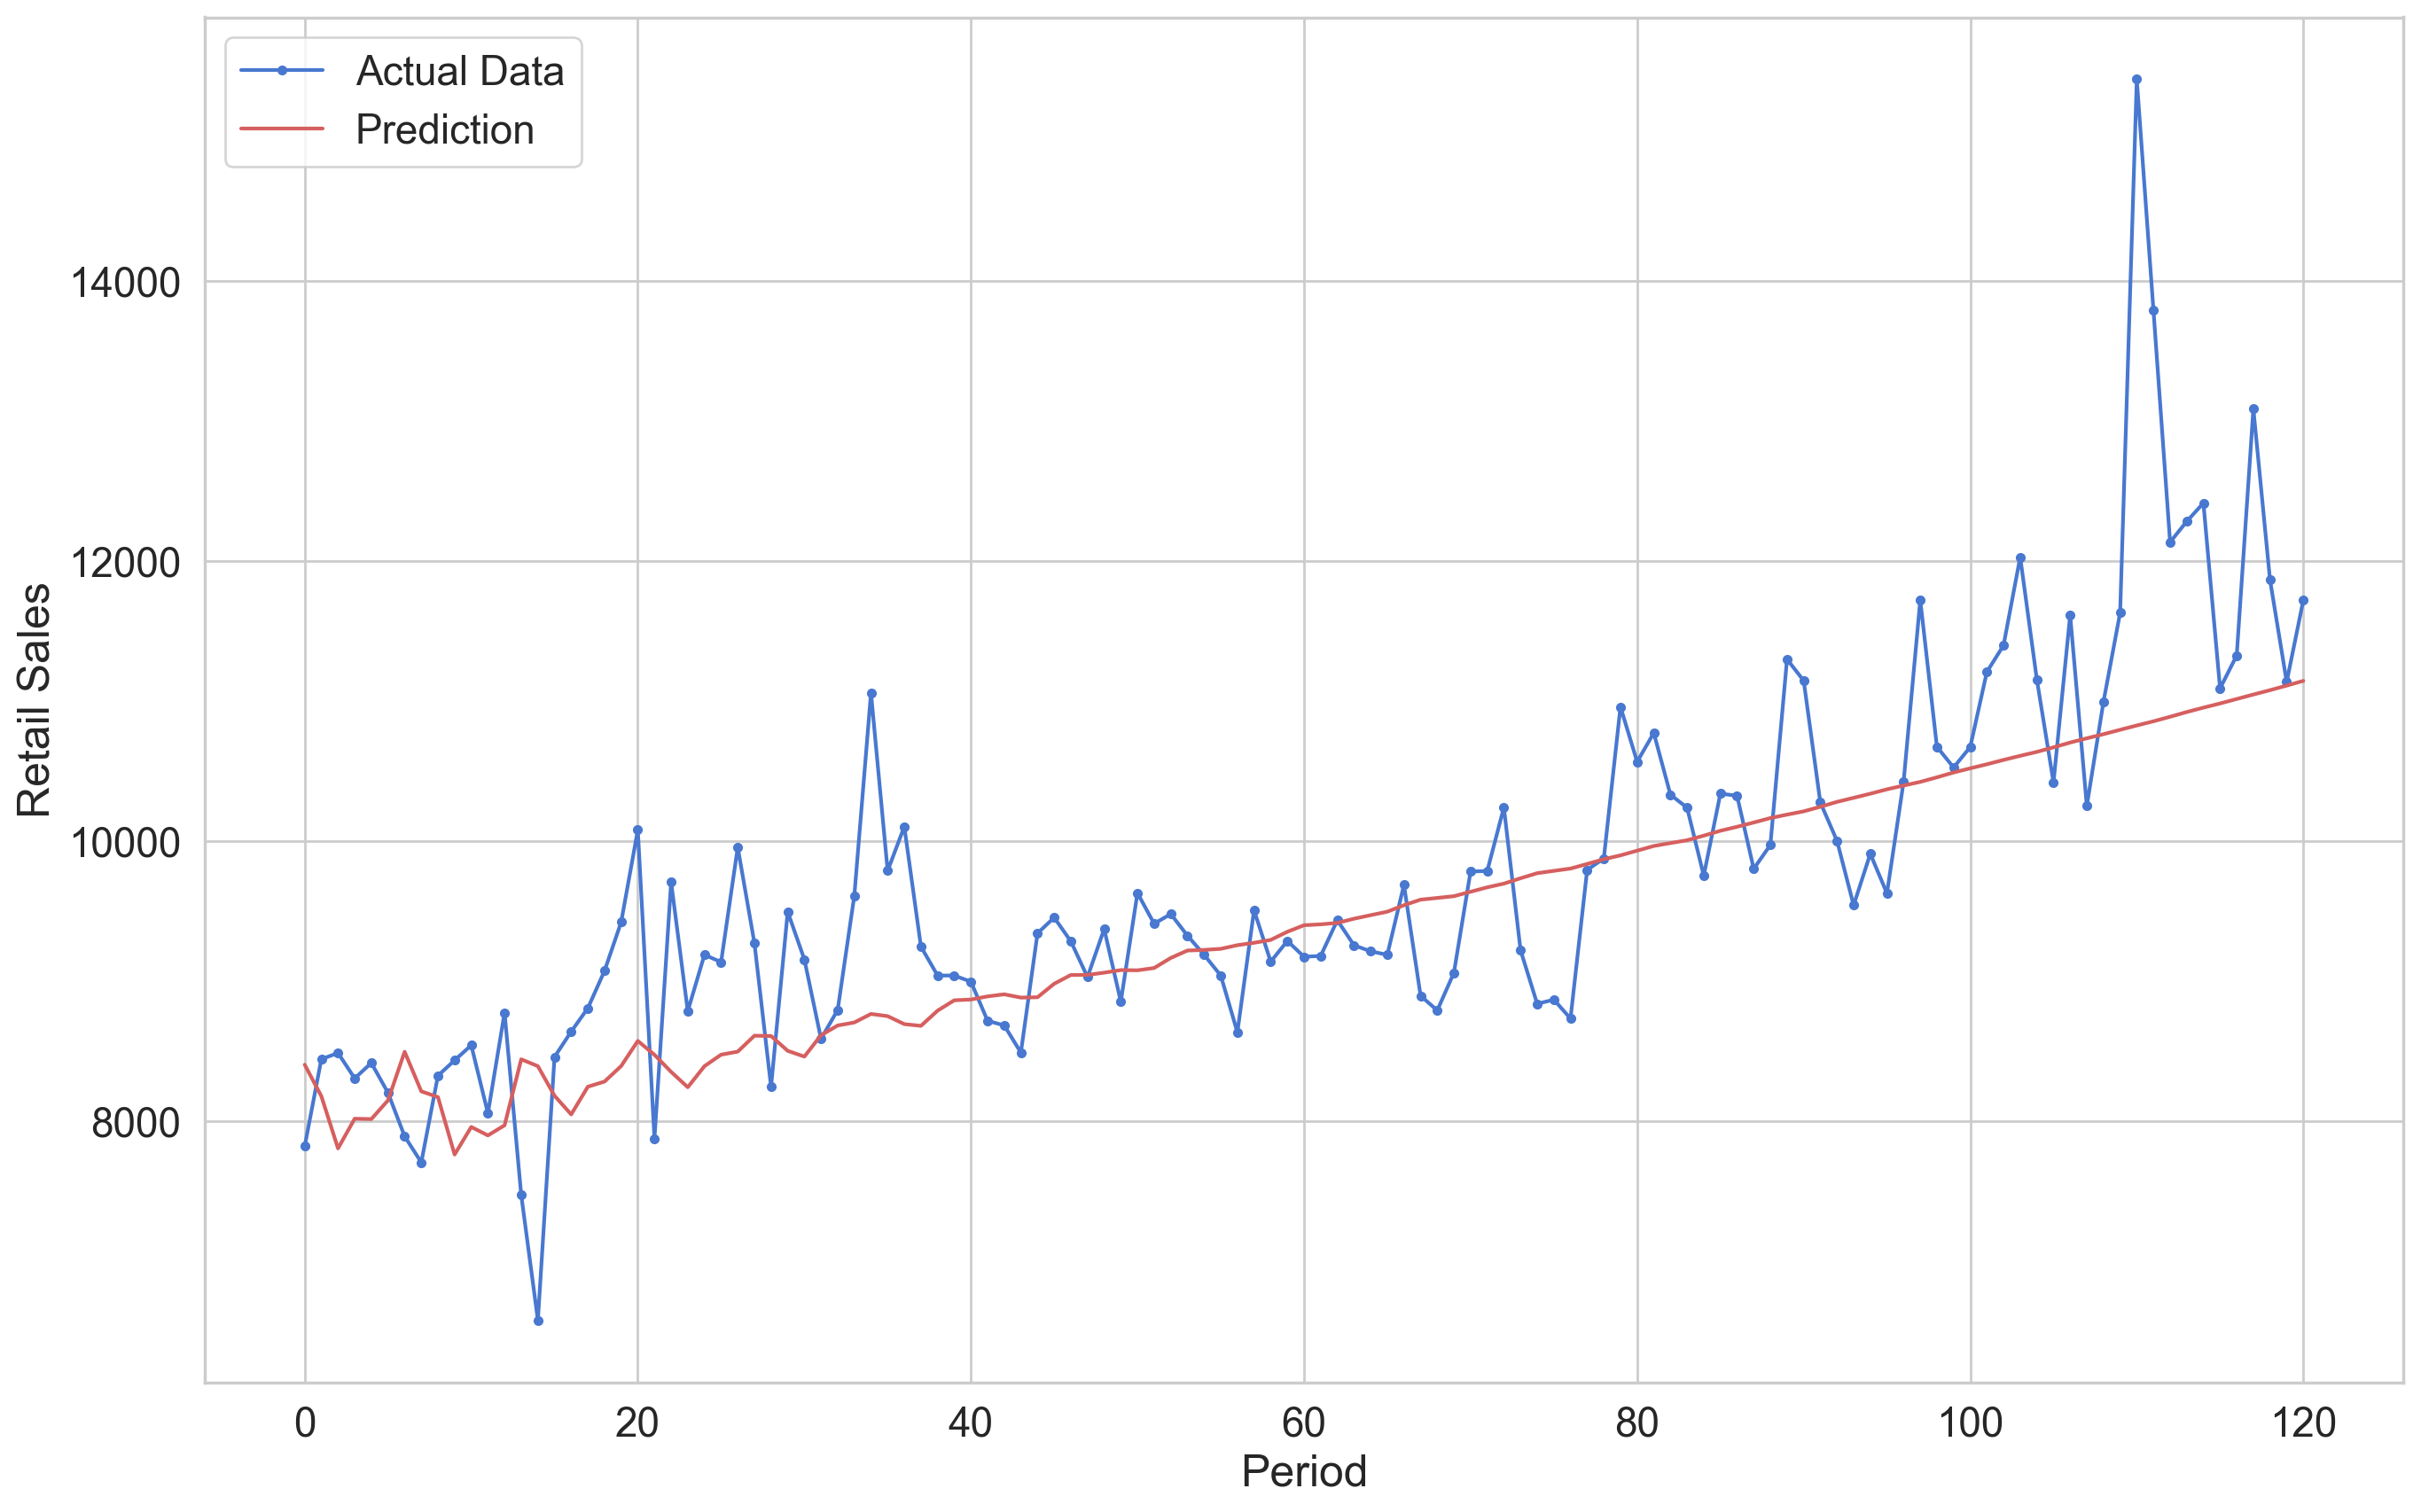

In [114]:
plt.plot(y_test, marker='.', label="Actual Data")
plt.plot(y_pred30, 'r', label="Prediction")
plt.ylabel('Retail Sales')
plt.xlabel('Period')
plt.legend()
plt.show()

In [115]:
# tính rmse
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred30))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 864.320


### MLP multivariate

In [116]:
df2 = pd.read_csv('Data/dataset.csv')
df2.tail()

,date,subs,comedy,drama,show,gala,talkshow,gameshow,music
816,2023-06-26,NaN,1,2,2,0,0,0,1
817,2023-06-27,NaN,1,2,2,0,0,0,1
818,2023-06-28,NaN,1,2,2,0,0,0,1
819,2023-06-29,NaN,1,2,2,0,0,0,1
820,2023-06-30,NaN,1,2,2,0,0,0,1


In [117]:
df2 = df2.drop(['date','gameshow','drama'], axis=1)

In [118]:
df_train = df2.dropna()

In [119]:
# split train & test data
n_train = int(len(df_train) * 0.8)
n_test = len(df_train) - n_train
train, test = df_train.iloc[0:548], df_train.iloc[548:685]
print(len(train), len(test))

548 137


In [120]:
def get_timeseries(x, n_steps=1):
    x_ts, y_ts = [], []
    for ii in range(len(x) - n_steps):
        v = x.iloc[ii:(ii + n_steps)].values
        x_ts.append(v)
        w = x.iloc[ii + n_steps][0]
        y_ts.append(w)
    return np.array(x_ts), np.array(y_ts)

In [121]:
n_steps = 30
n_features = 1

# convert to a time series dimension: [samples, n_steps, n_features]

x_train, y_train = get_timeseries(train, n_steps)
x_test, y_test = get_timeseries(test,n_steps)

print(x_train.shape, y_train.shape)

(518, 30, 6) (518,)


In [122]:
# define model
model2 = Sequential()
model2.add(Dense(50, activation='relu', input_dim=n_steps, input_shape=(30, 6)))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer=Adam(0.0001))

In [123]:
# fit model
history = model2.fit(x_train, y_train,epochs=500,batch_size=32,validation_split=0.1,shuffle=False)

Epoch 1/500
15/15 [==============================] - 1s 15ms/step - loss: 57563344.0000 - val_loss: 54407344.0000
Epoch 2/500
15/15 [==============================] - 0s 4ms/step - loss: 56254060.0000 - val_loss: 53116160.0000
Epoch 3/500
15/15 [==============================] - 0s 4ms/step - loss: 54953040.0000 - val_loss: 51832768.0000
Epoch 4/500
15/15 [==============================] - 0s 4ms/step - loss: 53662244.0000 - val_loss: 50562696.0000
Epoch 5/500
15/15 [==============================] - 0s 4ms/step - loss: 52386468.0000 - val_loss: 49309104.0000
Epoch 6/500
15/15 [==============================] - 0s 4ms/step - loss: 51128360.0000 - val_loss: 48073708.0000
Epoch 7/500
15/15 [==============================] - 0s 4ms/step - loss: 49889388.0000 - val_loss: 46857404.0000
Epoch 8/500
15/15 [==============================] - 0s 4ms/step - loss: 48670284.0000 - val_loss: 45660680.0000
Epoch 9/500
15/15 [==============================] - 0s 4ms/step - loss: 47471468.0000 - val_lo

In [124]:
y_pred = model2.predict(x_test)

# tạo mảng từ các vị trí 15 của các phần tử trong mảng y_pred
y_pred = np.array([y_pred[i][29] for i in range(len(y_pred))])

4/4 [==============================] - 0s 1ms/step


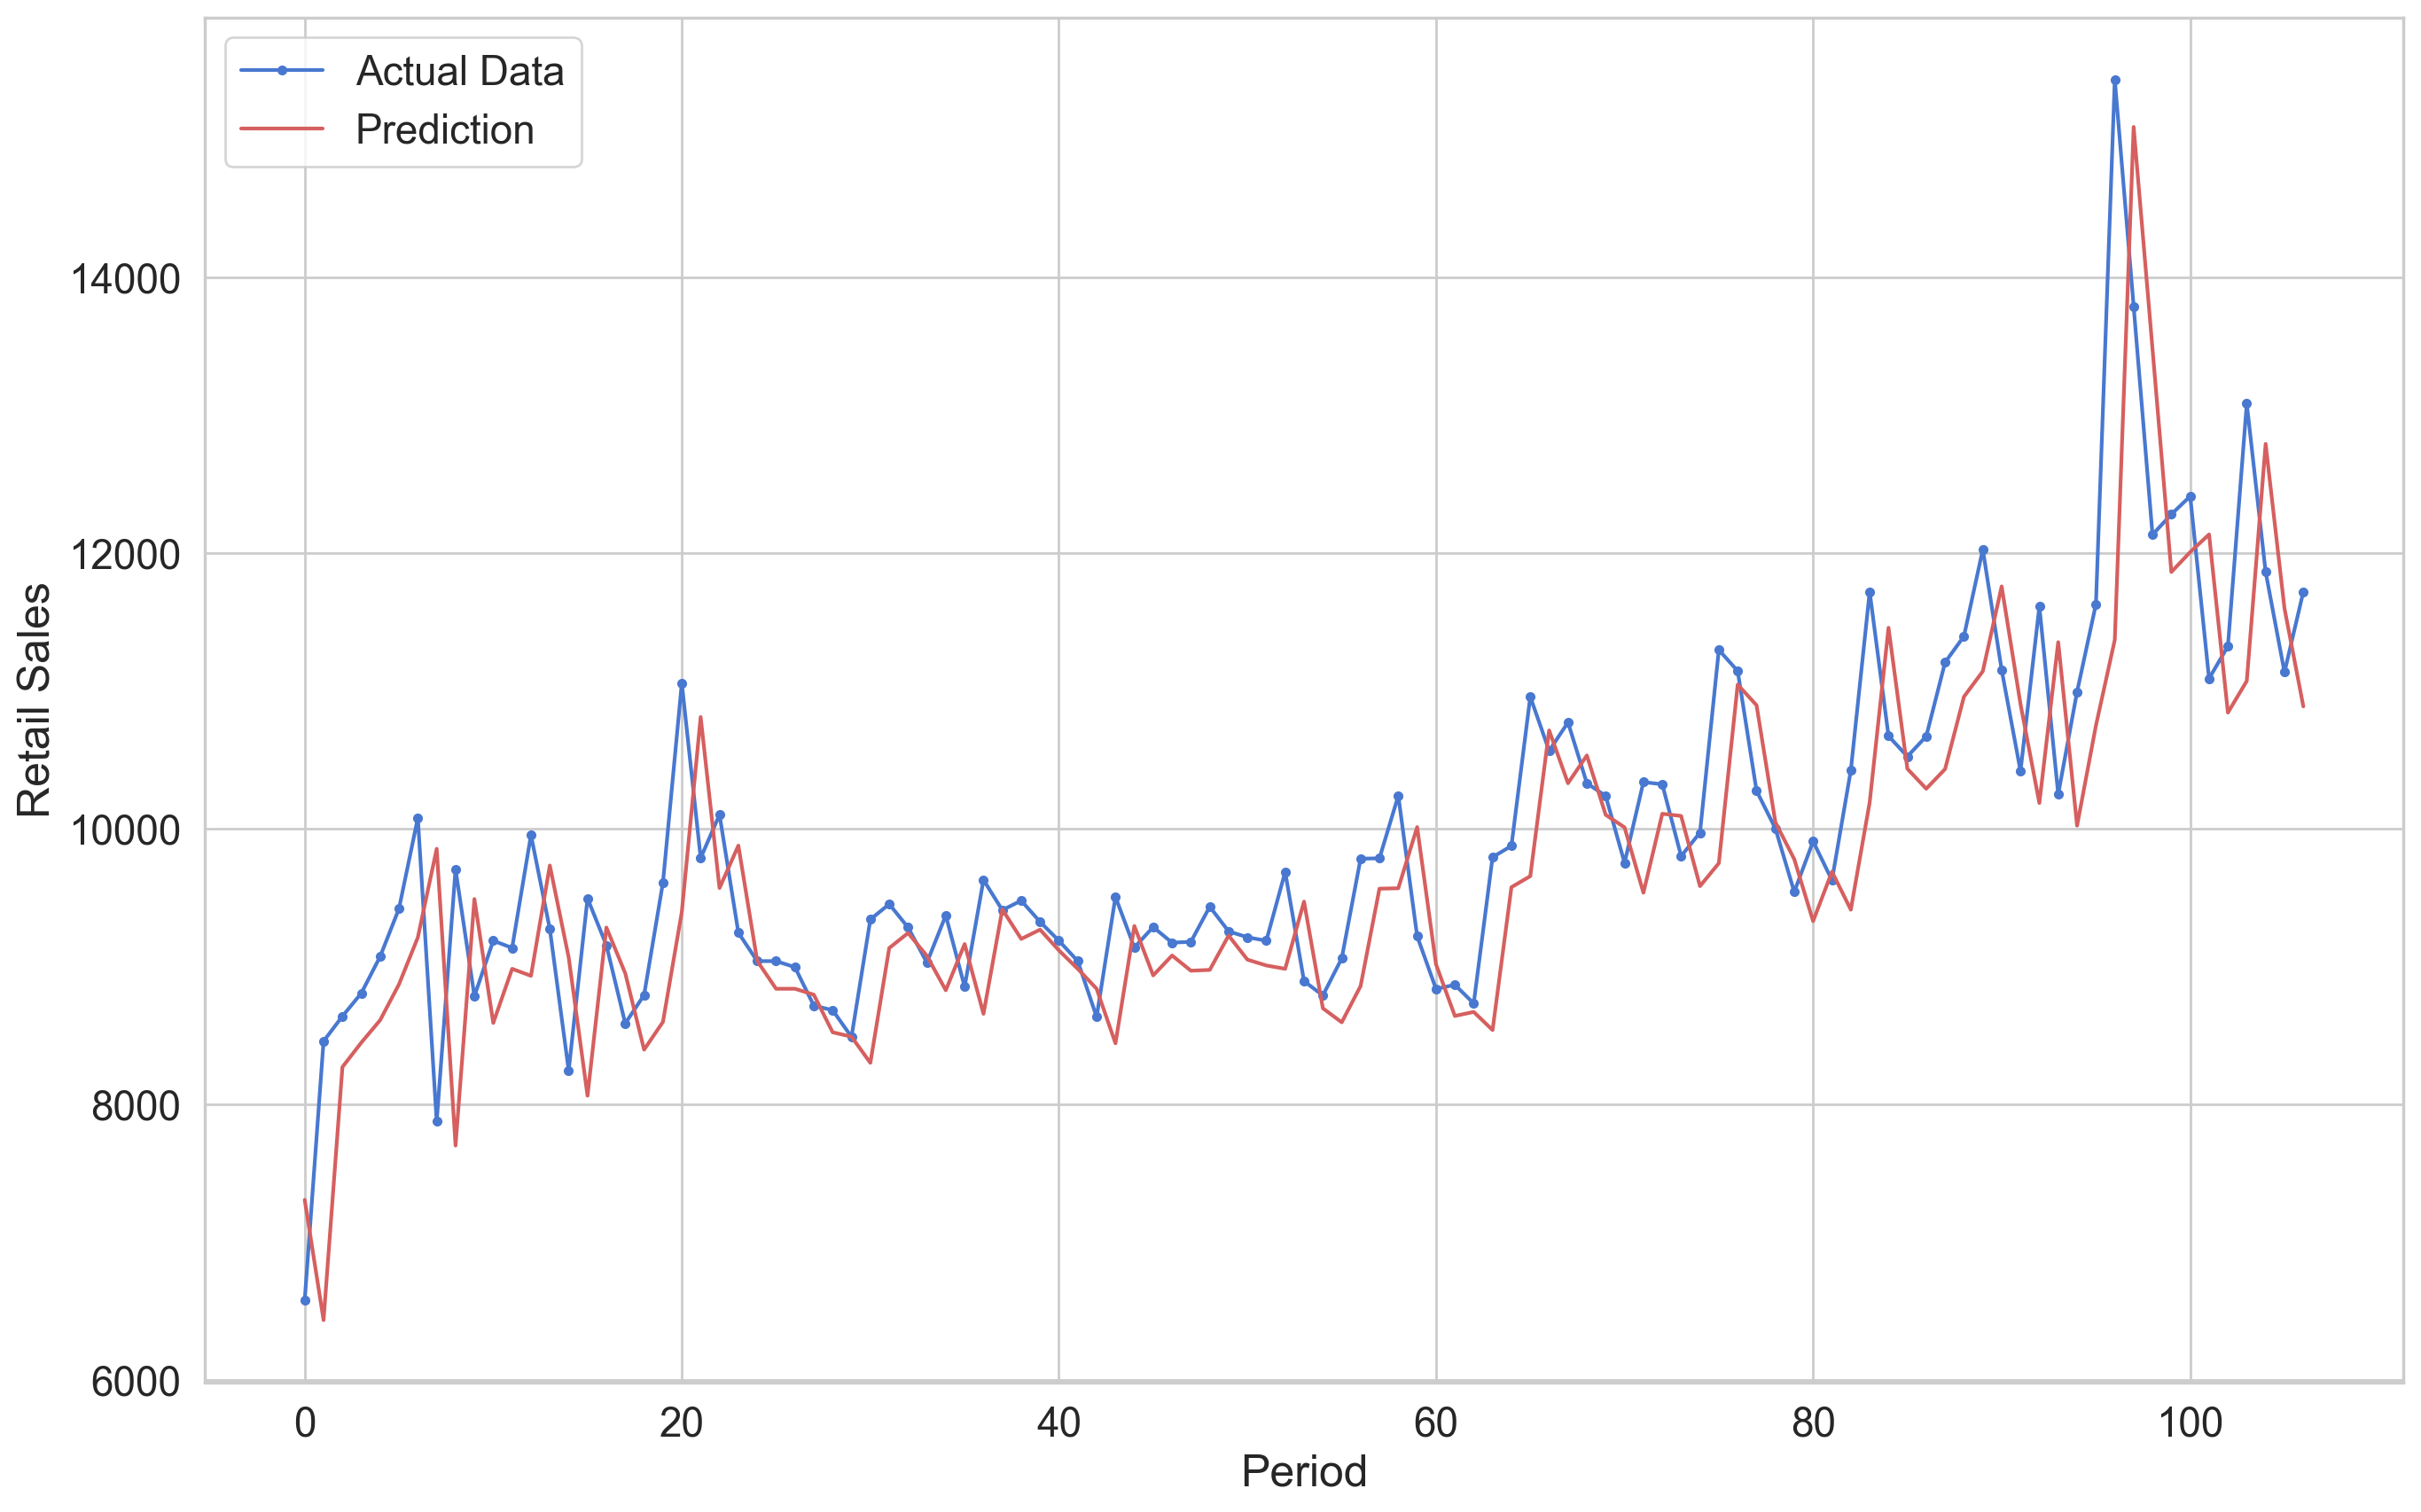

In [125]:
plt.plot(y_test, marker='.', label="Actual Data")
plt.plot(y_pred, 'r', label="Prediction")
plt.ylabel('Retail Sales')
plt.xlabel('Period')
plt.legend()
plt.show()

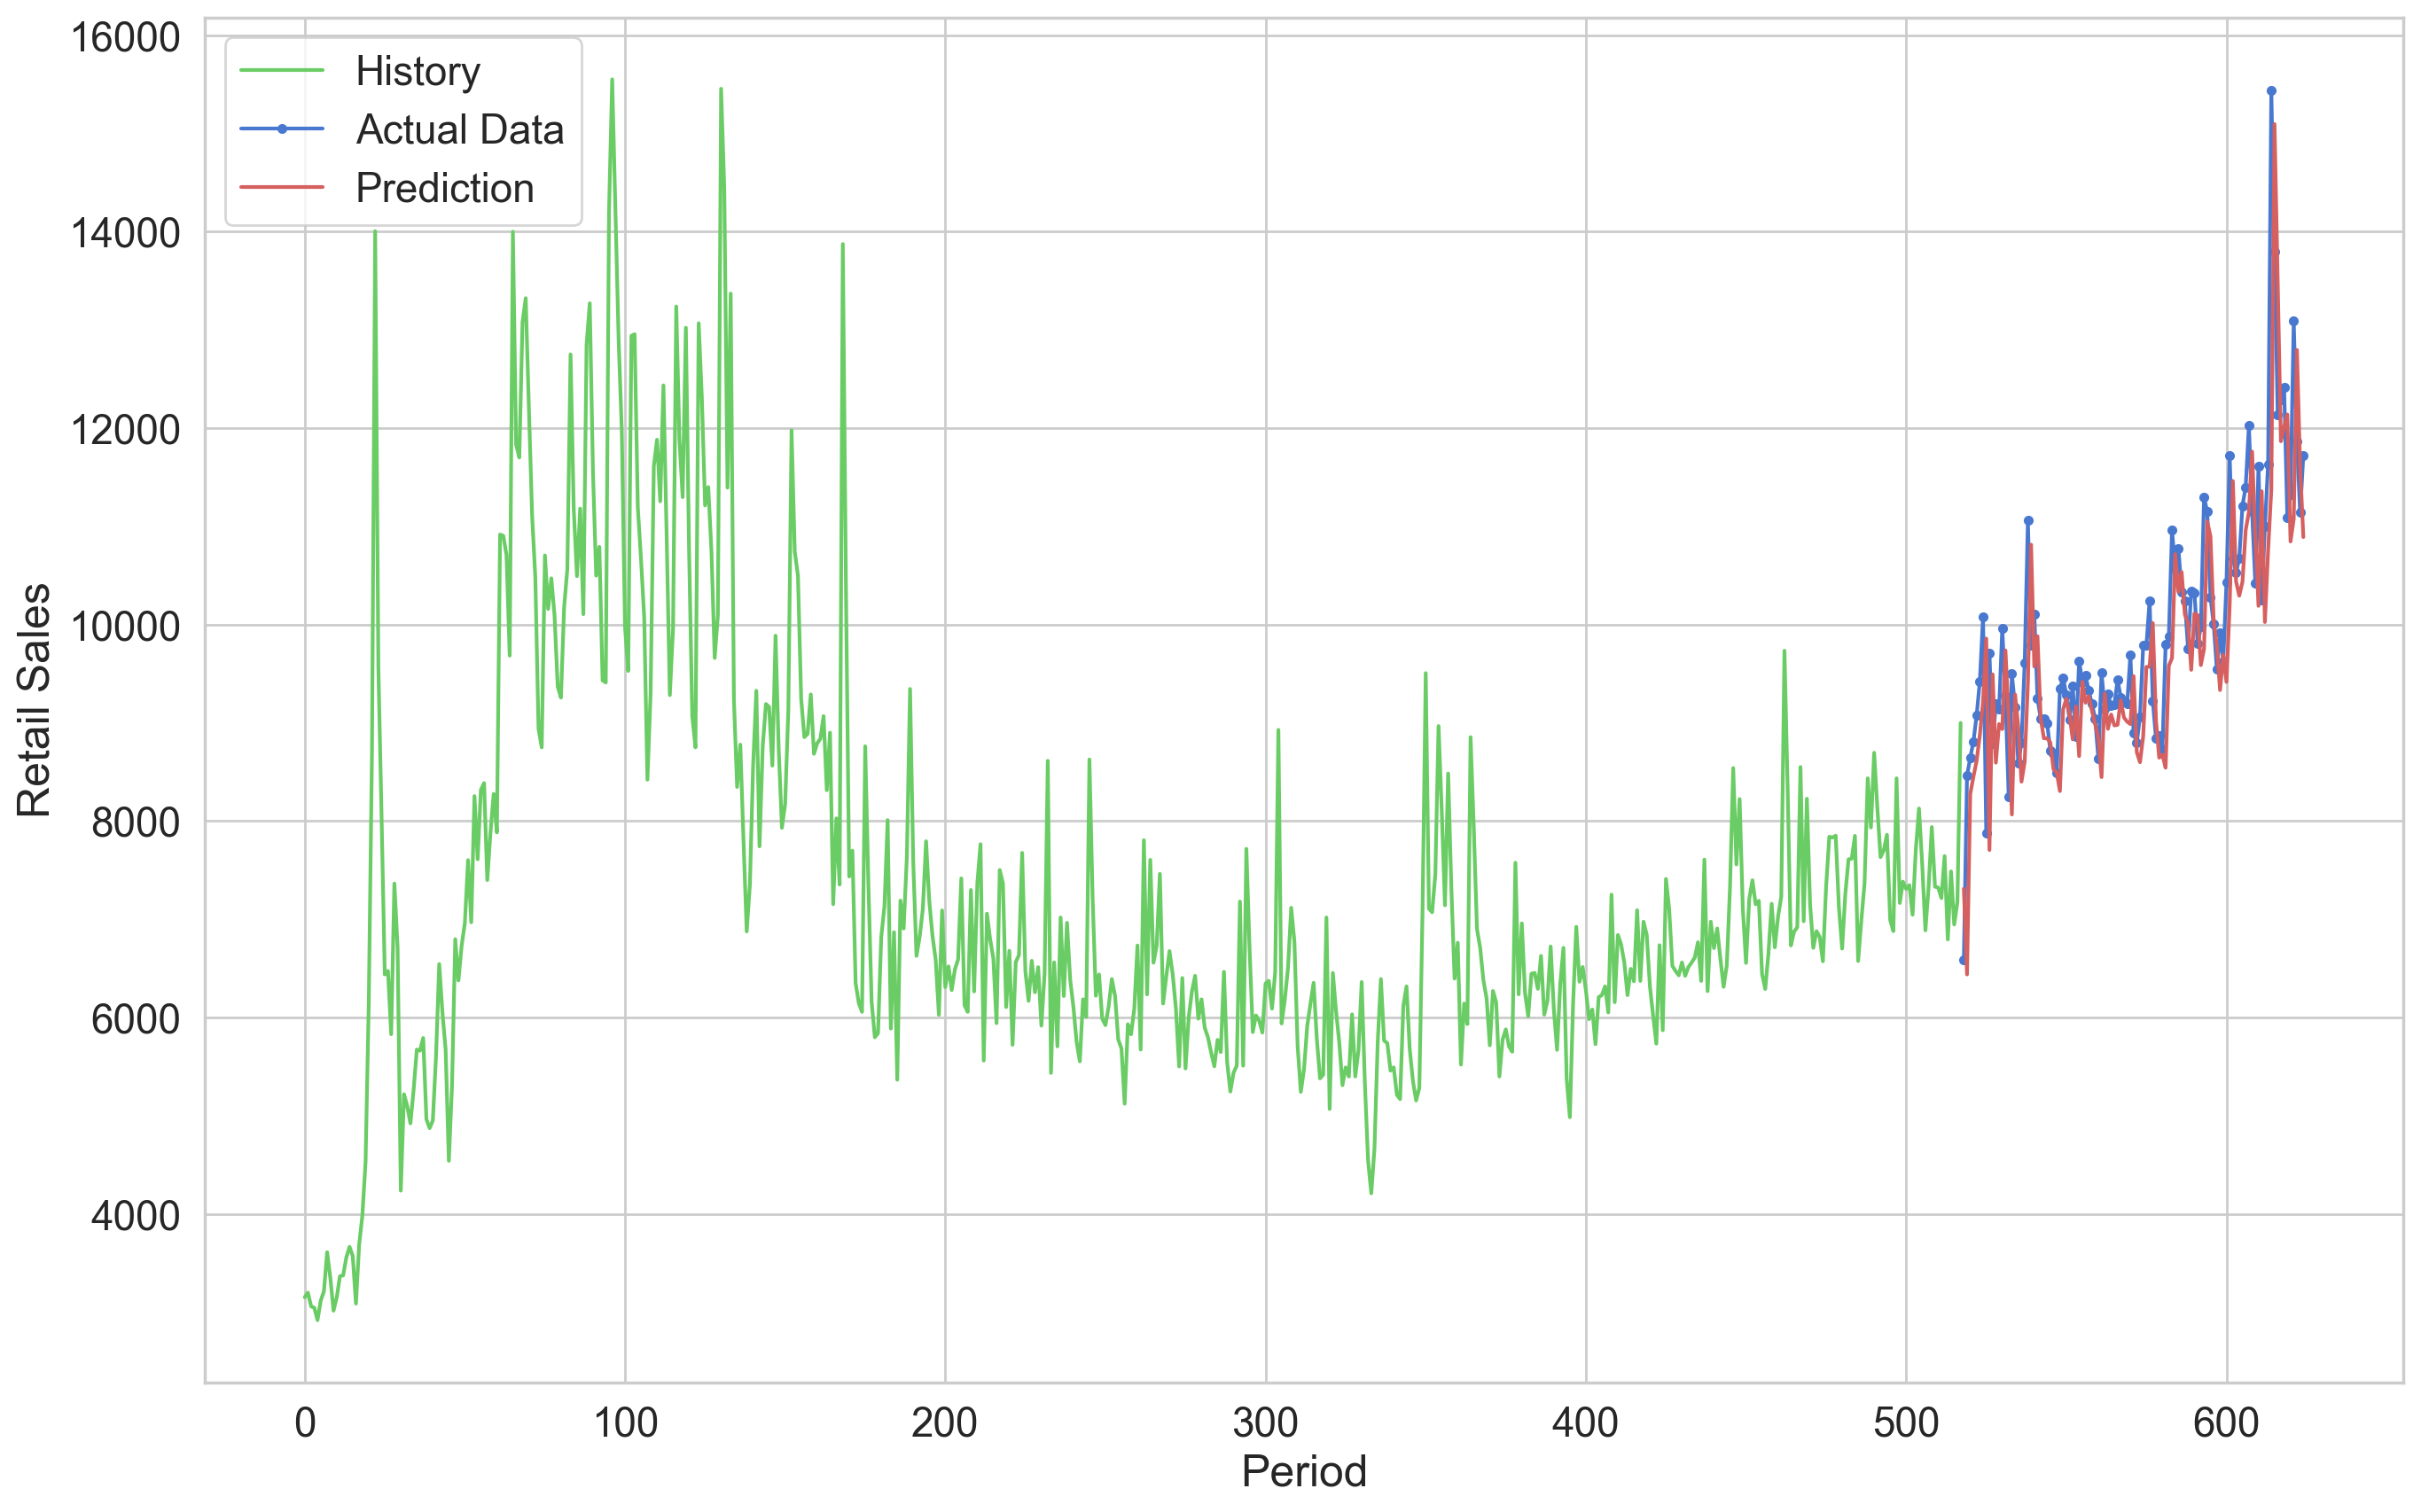

In [126]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="Actual Data")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="Prediction")
plt.ylabel('Retail Sales')
plt.xlabel('Period')
plt.legend()
plt.show()

In [127]:
df2[df2['subs'].isnull()]

,subs,comedy,show,gala,talkshow,music
685,NaN,1,0,0,1,0
686,NaN,1,0,0,1,0
687,NaN,1,0,0,1,0
688,NaN,1,0,0,1,0
689,NaN,1,0,0,1,0
...,...,...,...,...,...,...
816,NaN,1,2,0,0,1
817,NaN,1,2,0,0,1
818,NaN,1,2,0,0,1
819,NaN,1,2,0,0,1


In [128]:
x_input = df2[0:30].values
# dự báo cho i
y_pred = model2.predict(x_input.reshape(1, 30, 6))
# gán giá trị dự báo cho df2['subs'][i]
y_pred

1/1 [==============================] - 0s 24ms/step


array([[[2913.793 ],
        [2807.2632],
        [2953.8638],
        [3055.507 ],
        [2836.5833],
        [2841.47  ],
        [2807.2632],
        [2858.0845],
        [2868.8354],
        [2991.98  ],
        [3050.6204],
        [2964.6143],
        [2921.6118],
        [3390.734 ],
        [3219.7   ],
        [3387.802 ],
        [3401.4844],
        [3695.6636],
        [3733.7795],
        [5302.4077],
        [6874.9443],
        [2941.1584],
        [3529.5159],
        [3181.5837],
        [3133.694 ],
        [3061.371 ],
        [2956.796 ],
        [2782.8296],
        [2844.4019],
        [3147.377 ]]], dtype=float32)

In [140]:
# Loop from 685 to 911 (Python's range is exclusive of the stop value)
for i in range(685, 912):
    # Create an input array using the previous 30 rows
    x_input = df2[i-31:i-1].values
    
    # Predict the next value using the model
    y_pred = model2.predict(x_input.reshape(1, 30, 6))
    
    # Assign the predicted value to the 'subs' column at index i
    df2.at[i, 'subs'] = y_pred[0][-1]

# Display the last few rows of df2 to see the results
df2

1/1 [==============================] - 0s 24ms/step


,subs,comedy,show,gala,talkshow,music
0,2973.0,3.0,0.0,0.0,0.0,1.0
1,2864.0,3.0,0.0,0.0,0.0,1.0
2,3014.0,3.0,0.0,0.0,0.0,1.0
3,3118.0,3.0,0.0,0.0,0.0,1.0
4,2894.0,3.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
907,NaN,NaN,NaN,NaN,NaN,NaN
908,NaN,NaN,NaN,NaN,NaN,NaN
909,NaN,NaN,NaN,NaN,NaN,NaN
910,NaN,NaN,NaN,NaN,NaN,NaN


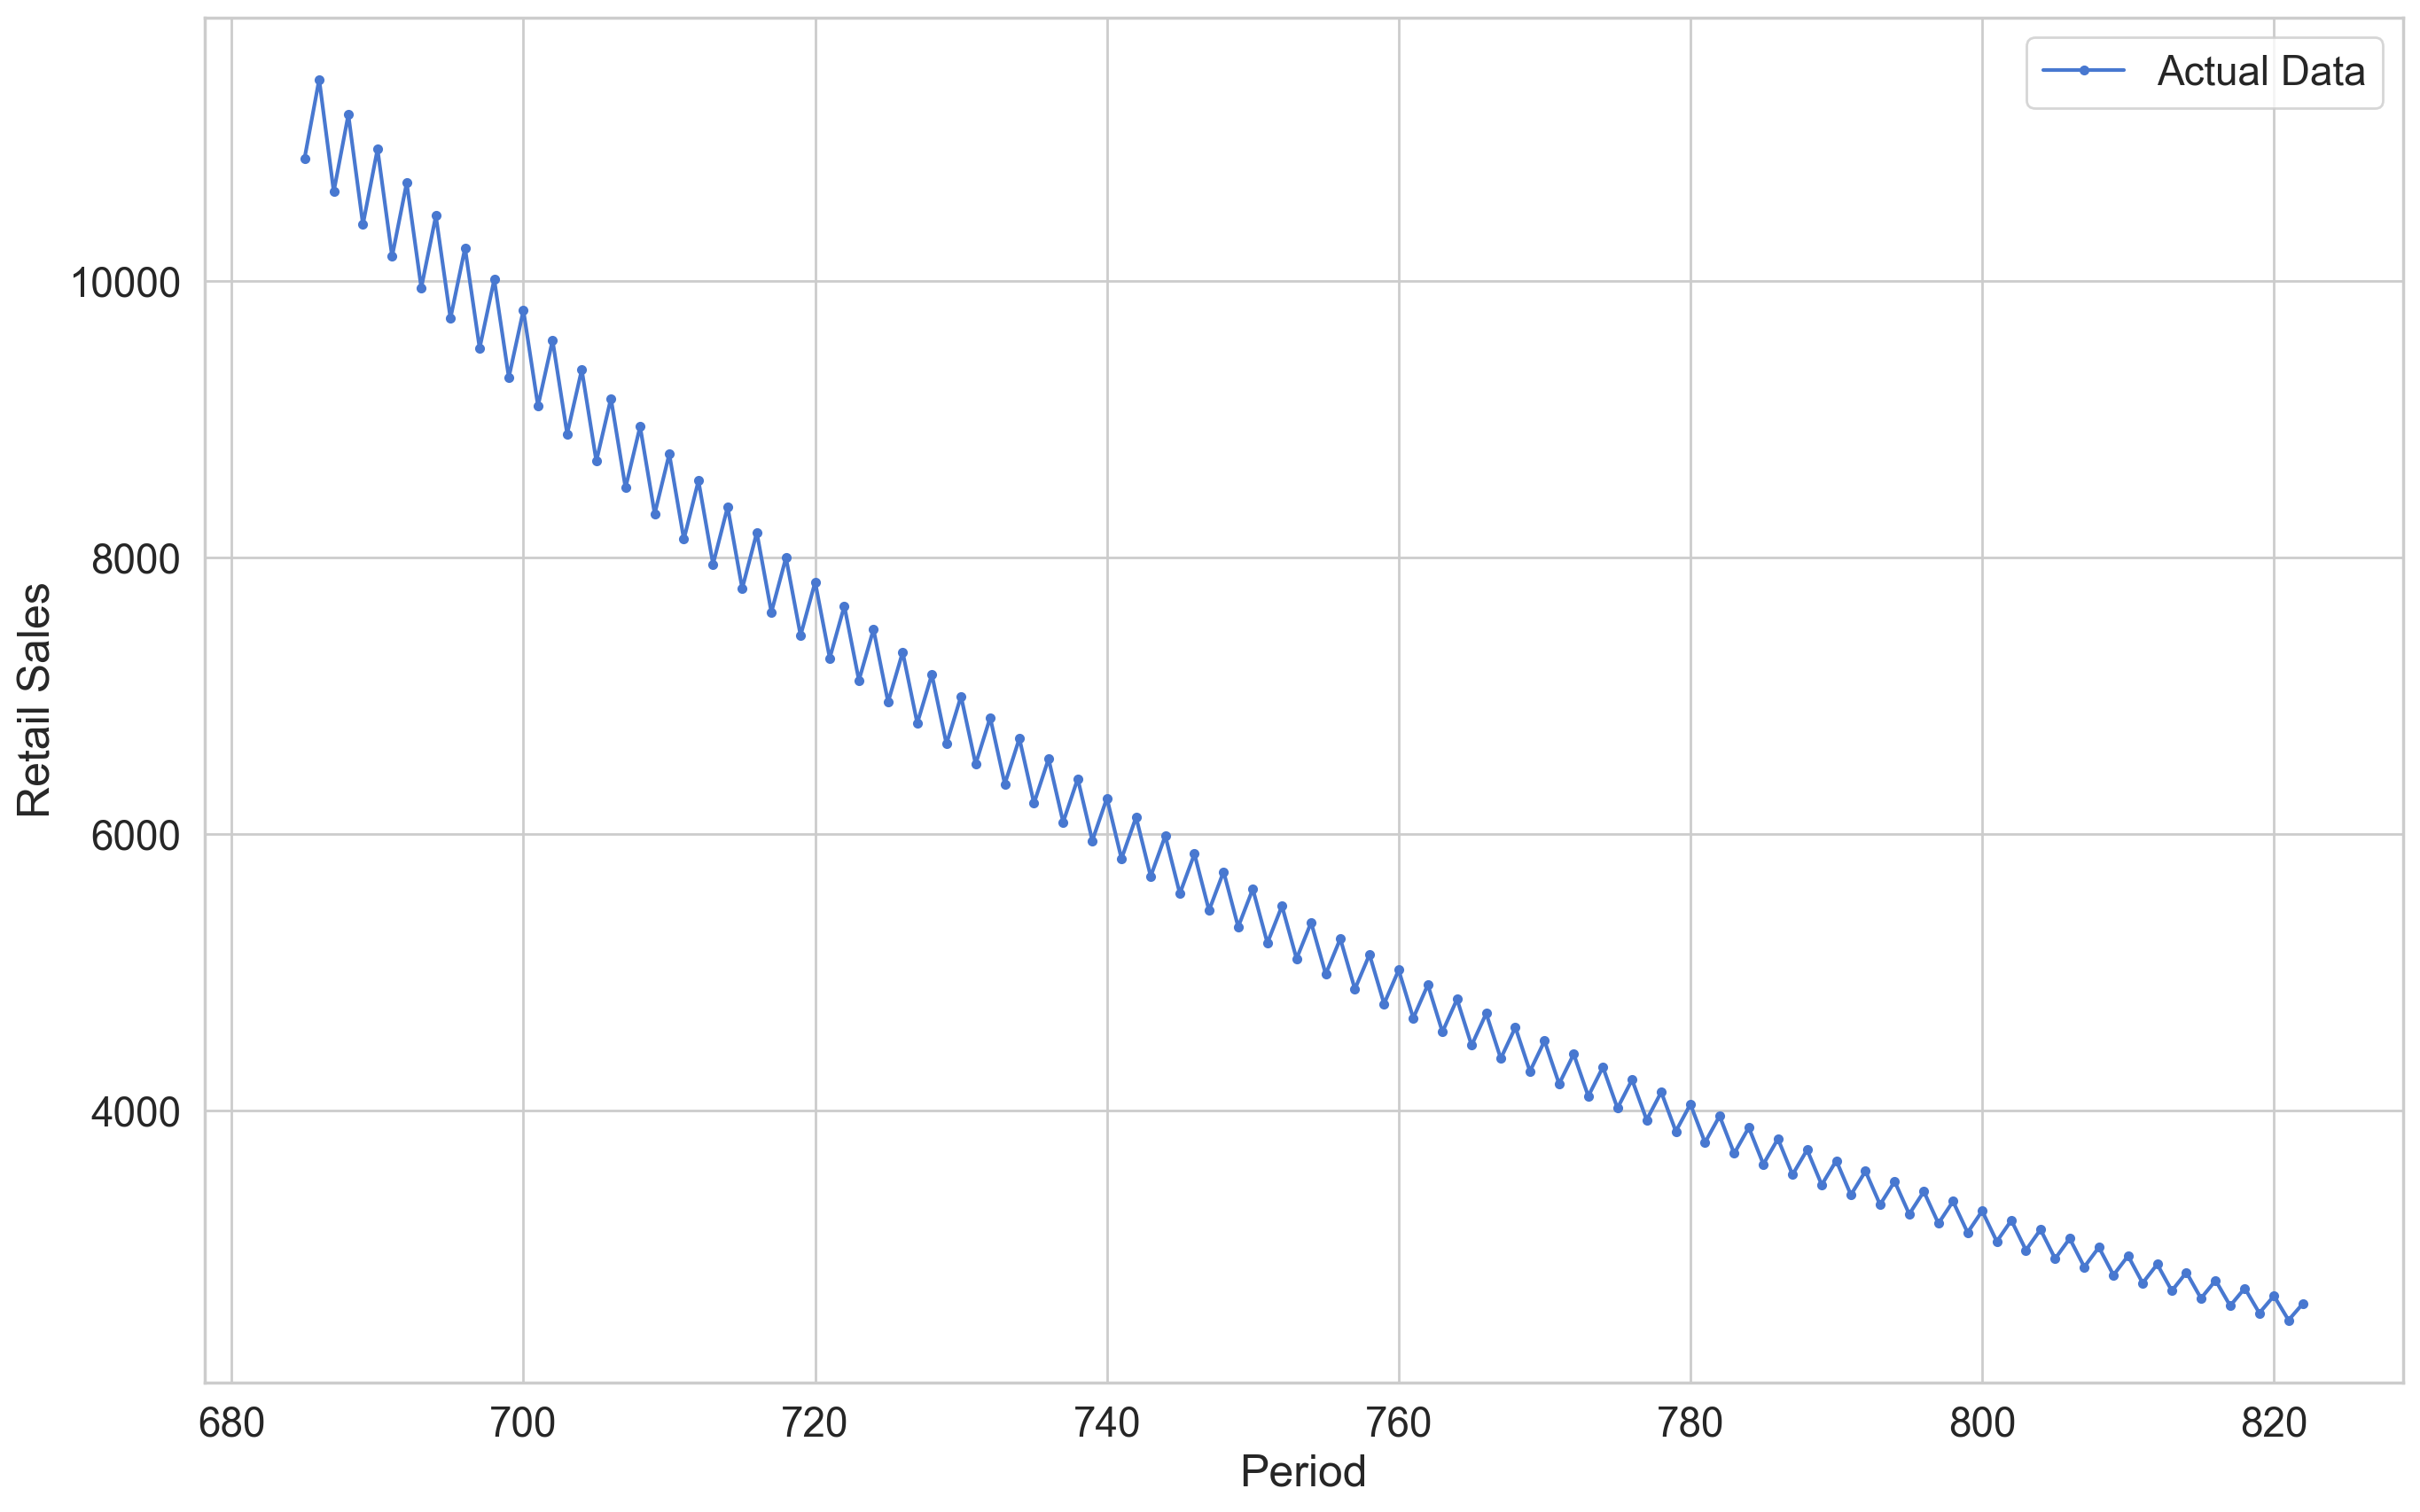

In [141]:
# plot dự báo
plt.plot(df2[685:912]['subs'], marker='.', label="Actual Data")
plt.ylabel('Retail Sales')
plt.xlabel('Period')
plt.legend()
plt.show()

https://github.com/yunssamfinance/DeepLearningInFinance/blob/main/ep21_TimeSeries_MLP.ipynb